In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
train_df = pd.read_csv('application_train_final_lof.csv')
print('Size of application_train data', train_df.shape)

Size of application_train data (204258, 94)


In [3]:
################################################################
# VISUALIZE THE DISTRIBUTIONS OF [TARGET] ON THE WHOLE DATASET #
################################################################

y = train_df['TARGET']
del train_df['TARGET']
del train_df['SK_ID_CURR']
pca = PCA()
standard_scaler = StandardScaler()
train_scaled = standard_scaler.fit_transform(train_df)
pca.fit(train_scaled)
pca.explained_variance_ # Check variance values

array([3.92630625e+00, 3.02680189e+00, 2.80019983e+00, 2.39057782e+00,
       2.31118913e+00, 1.99006297e+00, 1.91015898e+00, 1.65818757e+00,
       1.59580183e+00, 1.52221482e+00, 1.42956123e+00, 1.42019203e+00,
       1.34347366e+00, 1.29305055e+00, 1.27526139e+00, 1.24447050e+00,
       1.17553595e+00, 1.16040100e+00, 1.12790530e+00, 1.11282269e+00,
       1.09995589e+00, 1.07924622e+00, 1.07582722e+00, 1.06156247e+00,
       1.05491014e+00, 1.04759000e+00, 1.04343235e+00, 1.04038523e+00,
       1.03609529e+00, 1.03226378e+00, 1.02502543e+00, 1.02184846e+00,
       1.02128581e+00, 1.01795940e+00, 1.01632135e+00, 1.01298393e+00,
       1.01272047e+00, 1.01139420e+00, 1.00757507e+00, 1.00585049e+00,
       1.00497988e+00, 1.00391924e+00, 1.00283063e+00, 1.00251668e+00,
       1.00195099e+00, 1.00157442e+00, 1.00063491e+00, 1.00039100e+00,
       9.99817662e-01, 9.99004201e-01, 9.97412059e-01, 9.96623199e-01,
       9.95192119e-01, 9.93850685e-01, 9.86849226e-01, 9.82831411e-01,
      

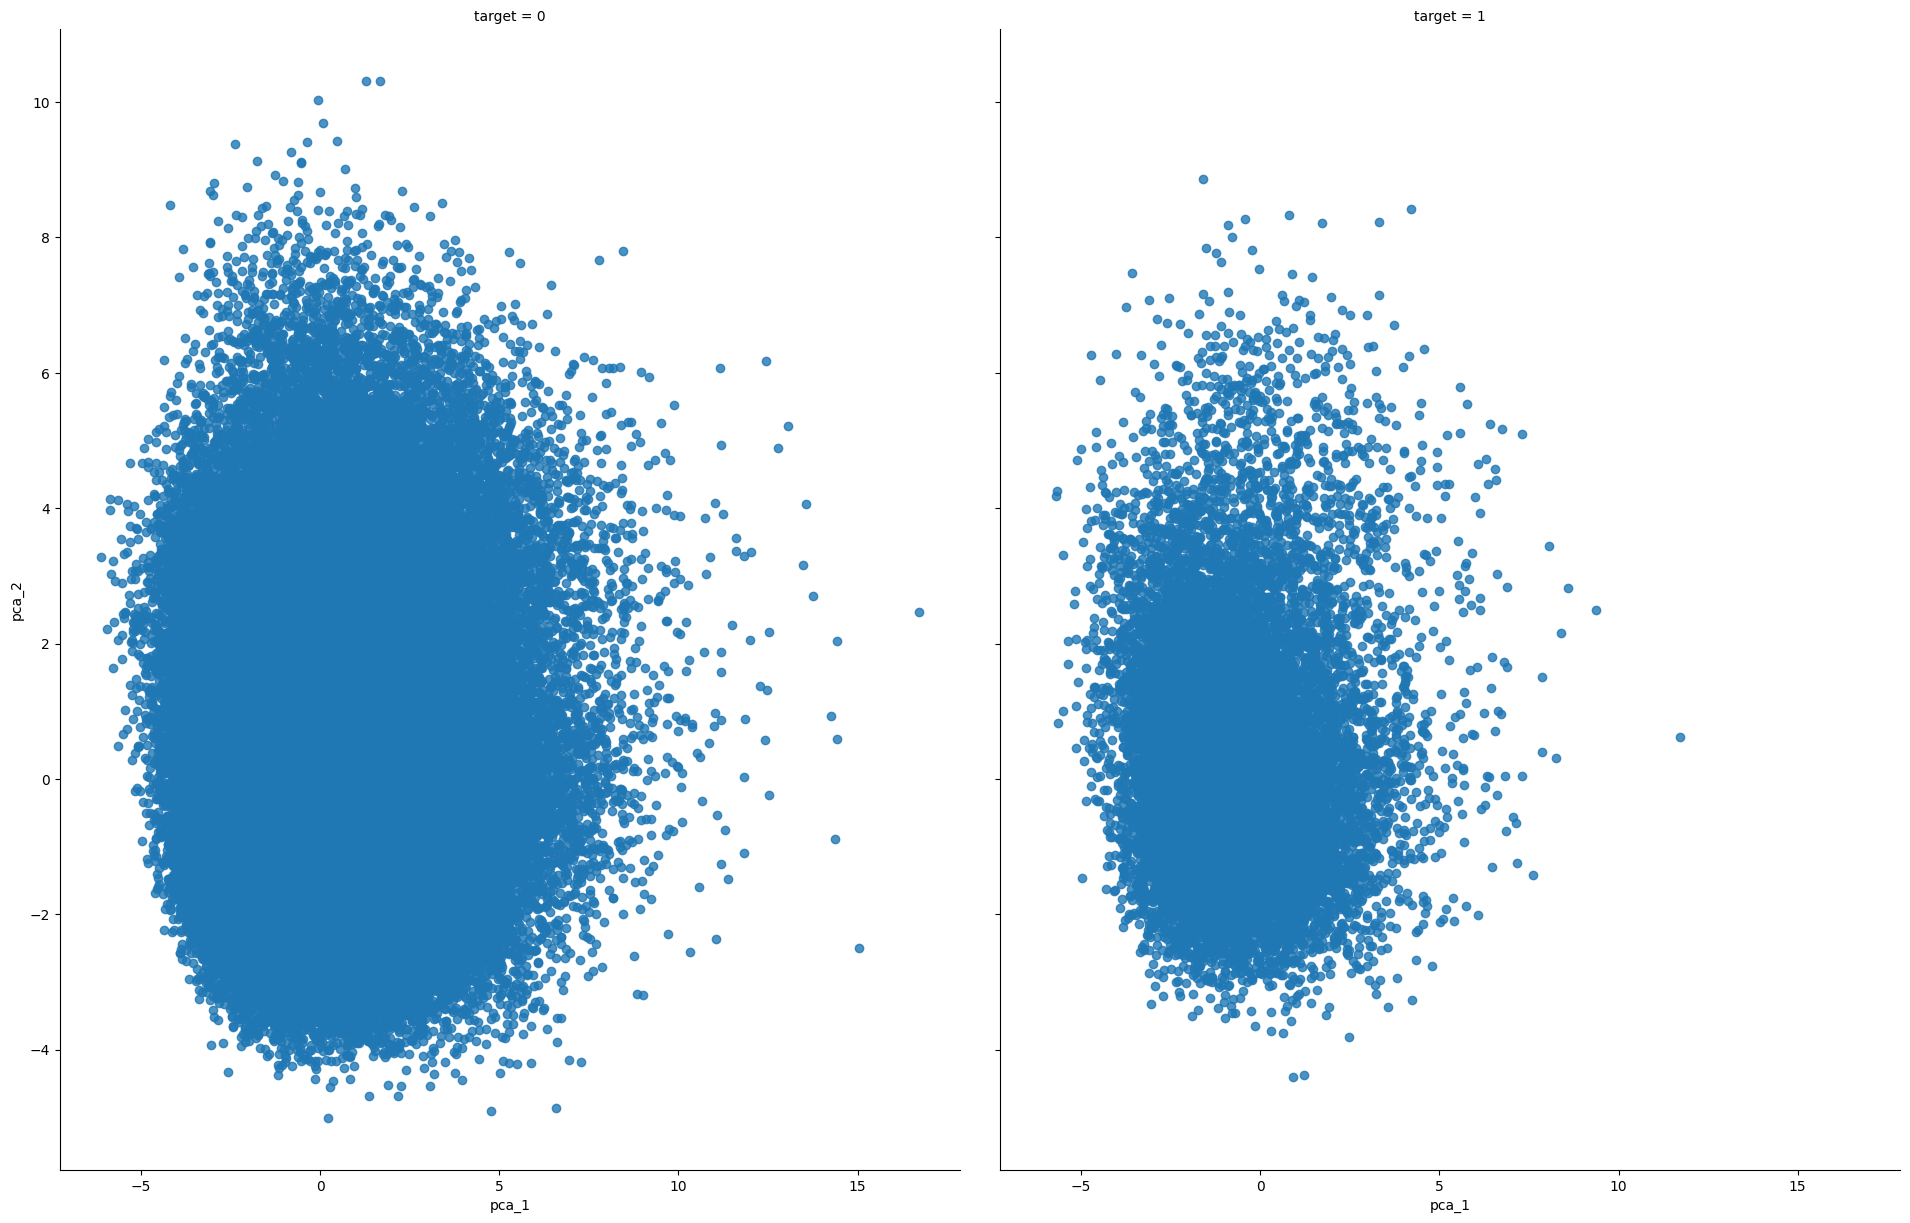

In [4]:
################ REDUCING THE DIMENSIONALITY ###############
pca_list = []
num_col = len(pca.explained_variance_)
for i in range(1,num_col + 1): pca_list.append('pca_%d' %i)
transformed = pca.transform(train_scaled)
ans = pd.DataFrame(transformed, columns = pca_list)
ans['target'] = y

################ THE DISTRIBUTIONS OF OBSERVATIONS WITH THE TARGET ###############
lm = sns.lmplot(x='pca_1', y='pca_2',col='target', data=ans, fit_reg=False)
ax = lm.axes
fig = plt.gcf()
fig.set_size_inches(20, 14)
plt.savefig('dist_obs_with_target.png')
plt.show()

In [5]:
################ CAN KNN ALGORITHM WORK ? ################
################        DO T-TEST         ################

# H0: 0 và 1 phân phối giống nhau trên bộ dữ liệu
# H1: 0 và 1 phân phối không giống nhau bộ dữ liệu
from scipy.stats import ttest_ind
default_pca_1 = ans.loc[ans['target']==1, ['pca_1']]
not_default_pca_1 = ans.loc[ans['target']==0, ['pca_1']]

default_pca_2 = ans.loc[ans['target']==1, ['pca_2']]
not_default_pca_2 = ans.loc[ans['target']==0, ['pca_2']]

print(ttest_ind(default_pca_1, not_default_pca_1))
print(ttest_ind(default_pca_2, not_default_pca_2))

Ttest_indResult(statistic=array([-46.38620391]), pvalue=array([0.]))
Ttest_indResult(statistic=array([25.2381465]), pvalue=array([2.51253955e-140]))


P-values < 0.01, reject H0

--> K-NEAREST NEIGHBOR ALGORITHM IS AVAILABLE, ACTUALLY!
#              LET'S BUILD MODEL                    #

In [6]:
X_train, X_test, y_train, y_test = train_test_split(ans, y, test_size=0.3, random_state=42)
k = 20
knn = KNeighborsClassifier(n_neighbors=k,weights='distance')
model = knn.fit(X_train, y_train)
y_predict_proba = model.predict_proba(X_test).tolist()
probabilities = np.array(y_predict_proba)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

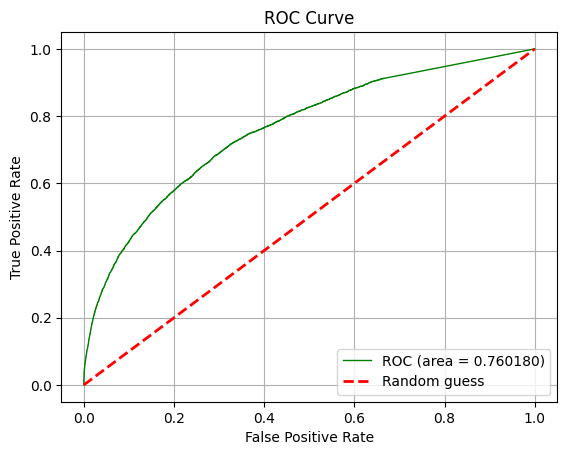

In [7]:
plt.plot(fpr, tpr, color='g', lw=1, label='ROC (area = %f)' %roc_auc)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label= 'Random guess')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig('ROC_of_KNCv1.png')
plt.show()